# **MAL Project** - Mobile Churn Forecasting
Mattéo Rousseau & Massil Gouachi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import uniform

# Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model training and evaluation
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Models
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier


## **Part I** - Data exploration

In [2]:
# Data Import
cell = pd.read_csv("celldata.csv")

features = [feature for feature in cell.columns if feature != "Churn"]
X, y = cell[features].copy(), cell[["Churn"]].copy()

types = {
    "CreditScore": "int64",
    "Age": "int64",
    "Tenure": "int64",
    "Balance": "float64",
    "NumOfProducts": "int64",
    "Salary": "int64",
    "Geography": "category",
    "Gender": "category",
    "HasCrCard": "boolean",
    "IsActiveMember": "boolean",
}

X = X.astype(types)
y = y.astype({"Churn": "boolean"})

cat_cols = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]
num_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "Salary"]
target = "Churn"

cell.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn
0,632,Germany,Female,50,5,107959.39,1,1,1,6985,1
1,649,France,Female,42,7,0.00,2,0,1,22974,0
2,595,France,Male,29,6,150685.79,1,1,0,87771,0
3,653,Spain,Male,35,6,116662.96,2,1,1,23864,0
4,559,Spain,Female,40,7,144470.77,1,1,1,18918,0


### **1.** Variables Description

In this section, we describe the variables of the dataset.

In [3]:
cell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     8000 non-null   int64  
 1   Geography       8000 non-null   object 
 2   Gender          8000 non-null   object 
 3   Age             8000 non-null   int64  
 4   Tenure          8000 non-null   int64  
 5   Balance         8000 non-null   float64
 6   NumOfProducts   8000 non-null   int64  
 7   HasCrCard       8000 non-null   int64  
 8   IsActiveMember  8000 non-null   int64  
 9   Salary          8000 non-null   int64  
 10  Churn           8000 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 687.6+ KB


In [4]:
cell.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,650.805000,38.871625,5.013000,76011.635494,1.533625,0.704750,0.515750,100211.396750,0.201125
std,96.721648,10.446006,2.897565,62402.105212,0.583448,0.456184,0.499783,57165.688096,0.400866
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,12.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51464.500000,0.000000
50%,652.000000,37.000000,5.000000,96846.565000,1.000000,1.000000,1.000000,100583.000000,0.000000
75%,718.000000,44.000000,7.000000,127593.625000,2.000000,1.000000,1.000000,149068.000000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.000000,1.000000


In [5]:
cell.isna().sum()

CreditScore       0
Geography         0
Gender            0
Age               0
Tenure            0
Balance           0
NumOfProducts     0
HasCrCard         0
IsActiveMember    0
Salary            0
Churn             0
dtype: int64

### **2.** Feature Analysis

In this section, we analyze each feature with respect to the result Variable *Churn*.

**Numerical features:**

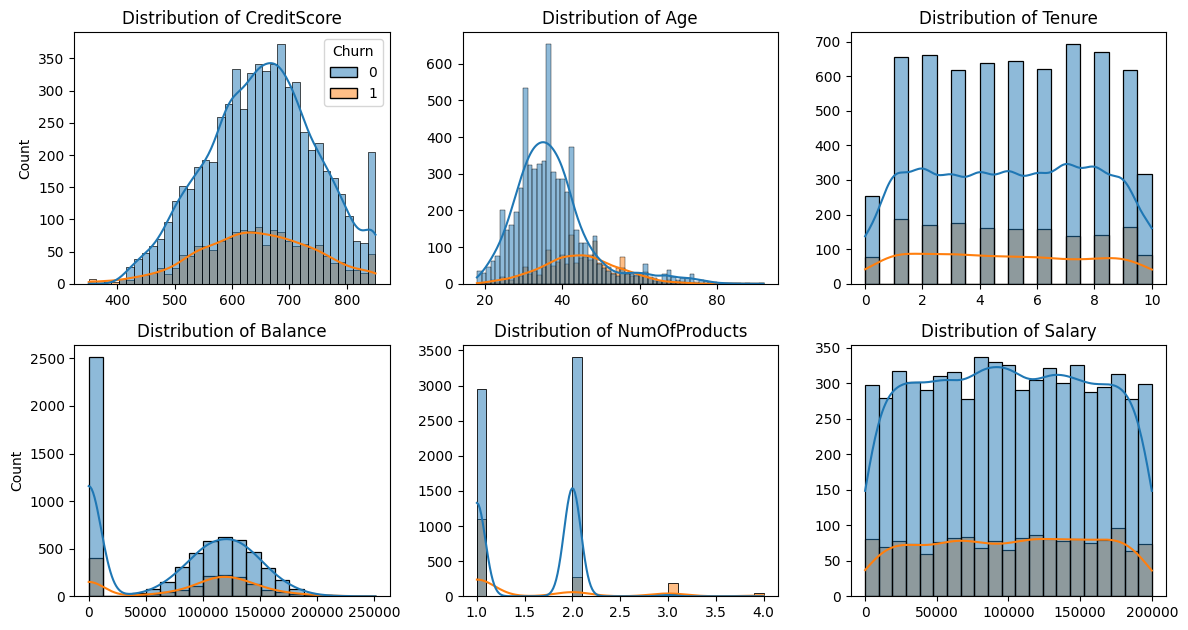

In [6]:
df = X.copy()
df["Churn"] = y["Churn"].astype(int)

ncols = 3
nrows = math.ceil(len(num_cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.histplot(df, x=col, hue=target, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel("")
    if i != 0:
        ax.get_legend().remove()
    if i not in [0,3]:
        ax.set_ylabel("")

fig.tight_layout()
plt.show()

# Save for LaTeX:
# fig.savefig("num_features_grid.png", dpi=300, bbox_inches="tight")

**Categorical Features:**

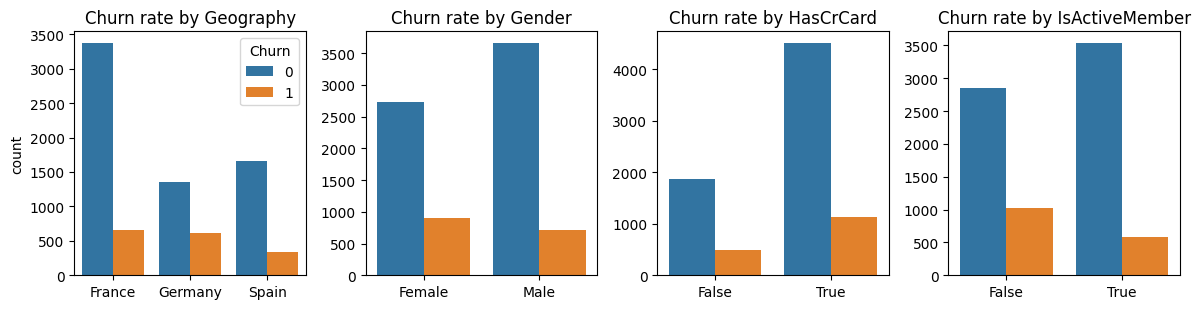

In [7]:
df = X.copy()
df["Churn"] = y["Churn"].astype(int)

ncols = 4
nrows = math.ceil(len(cat_cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(cat_cols):
    if col == target:
        continue
        
    ax = axes[i]
    sns.countplot(data=df, x=col, hue=target, ax=ax)
    ax.set_title(f"Churn rate by {col}")
    ax.set_xlabel("")
    if i != 0:
        ax.get_legend().remove()
    if i not in [0]:
        ax.set_ylabel("")

fig.tight_layout()
plt.show()

# Save for LaTeX:
#fig.savefig("cat_features_grid.png", dpi=300, bbox_inches="tight")

## **Part II** - Data processing

In [8]:
X_cv, X_eval, y_cv, y_eval = train_test_split(X, y, test_size=1/8, random_state=42)

OHE = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_cv_cat = OHE.fit_transform(X_cv[cat_cols])
X_eval_cat = OHE.transform(X_eval[cat_cols])

scaler = StandardScaler()
X_cv_num = scaler.fit_transform(X_cv[num_cols])
X_eval_num = scaler.transform(X_eval[num_cols])

X_cv = np.hstack([X_cv_num, X_cv_cat])
X_eval = np.hstack([X_eval_num, X_eval_cat])

y_cv = y_cv.to_numpy().ravel()
y_eval = y_eval.to_numpy().ravel()

## **Part III - Model training**

In [9]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

def model_evaluation(estimator, distribution, n_iter=20):
    clf = RandomizedSearchCV(estimator, distribution, n_iter=n_iter, scoring="average_precision", cv=cv, random_state=0)
    search = clf.fit(X_cv, y_cv)
    training_score = search.best_estimator_.score(X_cv, y_cv)
    eval_score = search.best_estimator_.score(X_eval, y_eval)
    y_proba = search.best_estimator_.predict_proba(X_eval)[:, 1]
    AUC_eval = average_precision_score(y_eval, y_proba)
    print(f"Best parameters: {search.best_params_}")
    print(f"{str(estimator)} accuracy training score: {training_score:5f}")
    print(f"{str(estimator)} accuracy evaluation score: {eval_score:5f}")
    print(f"{str(estimator)} precision-recall AUC cross-validation score: {search.best_score_:5f}")
    print(f"{str(estimator)} precision-recall AUC evaluation score: {AUC_eval:5f}")

    best_estimator = clone(estimator).set_params(**search.best_params_)
    best_estimator.fit(X_cv, y_cv)
    return best_estimator

In [10]:
logreg = LogisticRegression(solver="saga", max_iter=200, random_state=0)
logreg_dist = [
    {
        "penalty": ["l1", "l2"],
        "C": uniform(loc=0, scale=4)
    },
    {
        "penalty": ["elasticnet"],
        "C": uniform(loc=0, scale=4),
        "l1_ratio": uniform()
    }
]
logreg = model_evaluation(logreg, logreg_dist, n_iter=100)

Best parameters: {'C': np.float64(1.2528733277838038), 'penalty': 'l1'}
LogisticRegression(max_iter=200, random_state=0, solver='saga') accuracy training score: 0.812000
LogisticRegression(max_iter=200, random_state=0, solver='saga') accuracy evaluation score: 0.813000
LogisticRegression(max_iter=200, random_state=0, solver='saga') precision-recall AUC cross-validation score: 0.452998
LogisticRegression(max_iter=200, random_state=0, solver='saga') precision-recall AUC evaluation score: 0.458151


In [11]:
kNN = KNeighborsClassifier()
kNN_dist = dict(
    n_neighbors=range(1, 20),
    weights=["uniform", "distance"]
)

kNN = model_evaluation(kNN, kNN_dist, n_iter=38)

Best parameters: {'weights': 'distance', 'n_neighbors': 19}
KNeighborsClassifier() accuracy training score: 1.000000
KNeighborsClassifier() accuracy evaluation score: 0.848000
KNeighborsClassifier() precision-recall AUC cross-validation score: 0.641443
KNeighborsClassifier() precision-recall AUC evaluation score: 0.633607


In [12]:
LDA = LinearDiscriminantAnalysis(solver="lsqr")
LDA_dist = dict(
    shrinkage=uniform()
)

LDA = model_evaluation(LDA, LDA_dist, n_iter=100)

Best parameters: {'shrinkage': np.float64(0.004695476192547066)}
LinearDiscriminantAnalysis(solver='lsqr') accuracy training score: 0.810429
LinearDiscriminantAnalysis(solver='lsqr') accuracy evaluation score: 0.802000
LinearDiscriminantAnalysis(solver='lsqr') precision-recall AUC cross-validation score: 0.446072
LinearDiscriminantAnalysis(solver='lsqr') precision-recall AUC evaluation score: 0.449679


In [13]:
QDA = QuadraticDiscriminantAnalysis()
QDA_dist = dict(
    reg_param=uniform(),
)

QDA = model_evaluation(QDA, QDA_dist, n_iter=100)

Best parameters: {'reg_param': np.float64(0.06022547162926983)}
QuadraticDiscriminantAnalysis() accuracy training score: 0.838143
QuadraticDiscriminantAnalysis() accuracy evaluation score: 0.838000
QuadraticDiscriminantAnalysis() precision-recall AUC cross-validation score: 0.594337
QuadraticDiscriminantAnalysis() precision-recall AUC evaluation score: 0.596698


In [14]:
GNB = GaussianNB()
GNB_dist = {
    "var_smoothing": uniform(loc=0, scale=1e-3)
}

GNB = model_evaluation(GNB, GNB_dist, n_iter=100)

Best parameters: {'var_smoothing': np.float64(0.0009883738380592263)}
GaussianNB() accuracy training score: 0.826286
GaussianNB() accuracy evaluation score: 0.827000
GaussianNB() precision-recall AUC cross-validation score: 0.544483
GaussianNB() precision-recall AUC evaluation score: 0.537062


In [15]:
hist_grad_boost = HistGradientBoostingClassifier(max_iter=200)
hist_grad_boost_dist = {
    "learning_rate": uniform(loc=1e-6, scale=1e-2),
    "max_depth": [3, 5, 7, 9, 11],
    "l2_regularization": uniform()
}

hist_grad_boost = model_evaluation(hist_grad_boost, hist_grad_boost_dist, n_iter=20)

Best parameters: {'l2_regularization': np.float64(0.8579456176227568), 'learning_rate': np.float64(0.008473517387841254), 'max_depth': 9}
HistGradientBoostingClassifier(max_iter=200) accuracy training score: 0.872714
HistGradientBoostingClassifier(max_iter=200) accuracy evaluation score: 0.852000
HistGradientBoostingClassifier(max_iter=200) precision-recall AUC cross-validation score: 0.691852
HistGradientBoostingClassifier(max_iter=200) precision-recall AUC evaluation score: 0.684298


In [16]:
RF = RandomForestClassifier()
RF_dist = {
    "max_depth": [7, 9, 11, 13],
    "n_estimators": [200, 300, 400],
    "min_samples_split": [2, 5, 10],
}

RF = model_evaluation(RF, RF_dist, n_iter=20)

Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 9}
RandomForestClassifier() accuracy training score: 0.887143
RandomForestClassifier() accuracy evaluation score: 0.859000
RandomForestClassifier() precision-recall AUC cross-validation score: 0.693801
RandomForestClassifier() precision-recall AUC evaluation score: 0.680889


In [17]:
extratrees = ExtraTreesClassifier()
extratrees_dist = {
    "max_depth": [3, 5, 7, 9, 11, 13],
    "n_estimators": [100, 200, 300, 400],
    "min_samples_split": [2, 5, 10, 15],
}

extratrees = model_evaluation(extratrees, extratrees_dist, n_iter=20)

Best parameters: {'n_estimators': 400, 'min_samples_split': 5, 'max_depth': 11}
ExtraTreesClassifier() accuracy training score: 0.886286
ExtraTreesClassifier() accuracy evaluation score: 0.844000
ExtraTreesClassifier() precision-recall AUC cross-validation score: 0.690534
ExtraTreesClassifier() precision-recall AUC evaluation score: 0.667848


In [18]:
adaboost = AdaBoostClassifier(random_state=1)
adaboost_dist = {
    "estimator": [DecisionTreeClassifier(
        max_depth=i,
        min_samples_leaf=10
    ) for i in range(2, 5)],
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": uniform(loc=1e-6, scale=5e-1),
}

adaboost = model_evaluation(adaboost, adaboost_dist, n_iter=20)

Best parameters: {'estimator': DecisionTreeClassifier(max_depth=4, min_samples_leaf=10), 'learning_rate': np.float64(0.40608536438774656), 'n_estimators': 200}
AdaBoostClassifier(random_state=1) accuracy training score: 0.870857
AdaBoostClassifier(random_state=1) accuracy evaluation score: 0.855000
AdaBoostClassifier(random_state=1) precision-recall AUC cross-validation score: 0.698464
AdaBoostClassifier(random_state=1) precision-recall AUC evaluation score: 0.678671


In [19]:
stack = StackingClassifier(
    estimators=[
        ("rf", RF),
        ("hgb", hist_grad_boost),
        ("lr", logreg),
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    stack_method="predict_proba"
)
stack.fit(X_cv, y_cv)

eval_score = stack.score(X_eval, y_eval)
training_score = stack.score(X_cv, y_cv)
y_train_proba = stack.predict_proba(X_cv)[:, 1]
AUC_train = average_precision_score(y_cv, y_train_proba)
y_proba = stack.predict_proba(X_eval)[:, 1]
AUC_eval = average_precision_score(y_eval, y_proba)
print(f"StackingClassifier accuracy training score: {training_score:5f}")
print(f"StackingClassifier accuracy evaluation score: {eval_score:5f}")
print(f"StackingClassifier precision-recall AUC training score: {AUC_train:5f}")
print(f"StackingClassifier precision-recall AUC evaluation score: {AUC_eval:5f}")

StackingClassifier accuracy training score: 0.883000
StackingClassifier accuracy evaluation score: 0.866000
StackingClassifier precision-recall AUC training score: 0.797624
StackingClassifier precision-recall AUC evaluation score: 0.686431


## **Part IV - Classification Analysis**

In [20]:
RF = RandomForestClassifier(n_estimators = 200, min_samples_split=10, max_depth=11 )
RF.fit(X_cv, y_cv)

,n_estimators,200
,criterion,'gini'
,max_depth,11
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### **1. Confusion Matrix**

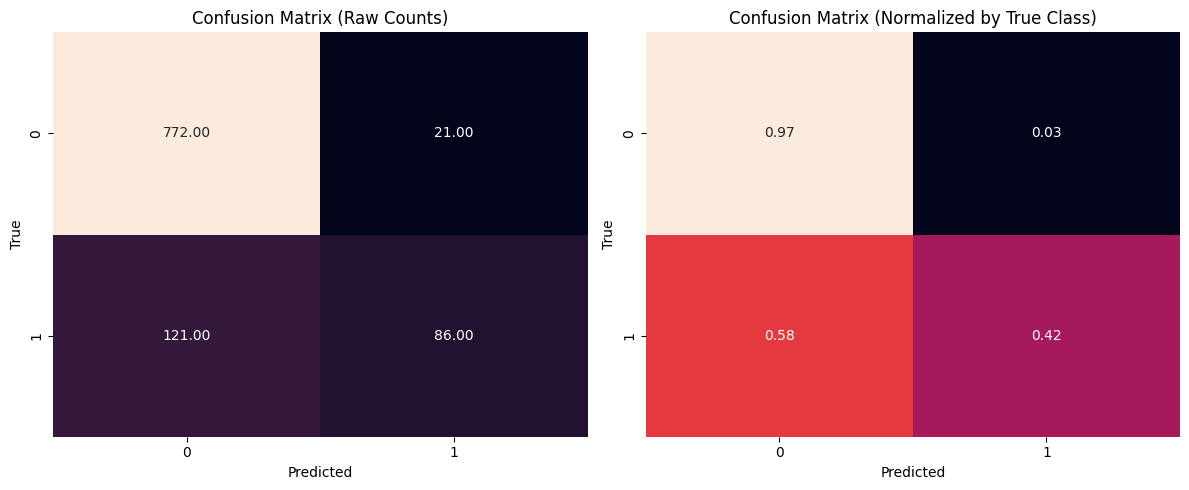

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = RF.predict(X_eval)
cm_raw = confusion_matrix(y_eval, y_pred)
cm_norm = confusion_matrix(y_eval, y_pred, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    cm_raw,
    annot=True,
    fmt=".2f",
    ax=axes[0],cbar=False,
)
axes[0].set_title("Confusion Matrix (Raw Counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    ax=axes[1],cbar=False,
)
axes[1].set_title("Confusion Matrix (Normalized by True Class)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

#### **2. Confusion matrix per col**

In [24]:
_, X_eval_raw, _, _ = train_test_split(X, y, test_size=1/8, random_state=42)
eval_df = pd.DataFrame(X_eval_raw, columns=X.columns)
eval_df["true"] = y_eval
eval_df["pred"] = y_pred

eval_df["segment"] = np.select(
    [
        (eval_df["true"] == 1) & (eval_df["pred"] == 1),  # TP
        (eval_df["true"] == 1) & (eval_df["pred"] == 0),  # FN
        (eval_df["true"] == 0) & (eval_df["pred"] == 1),  # FP
        (eval_df["true"] == 0) & (eval_df["pred"] == 0),  # TN
    ],
    ["TP", "FN", "FP", "TN"],
    default=None
)

eval_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,true,pred,segment
2215,796,Germany,Male,39,5,86350.87,2,False,False,105081,False,False,TN
2582,624,France,Male,36,6,0.00,2,False,False,84750,False,False,TN
1662,742,Spain,Male,24,8,0.00,2,True,False,4070,False,False,TN
3027,850,Spain,Male,22,3,0.00,1,True,True,144386,False,False,TN
4343,645,Germany,Female,37,2,136925.09,2,False,True,153400,False,False,TN


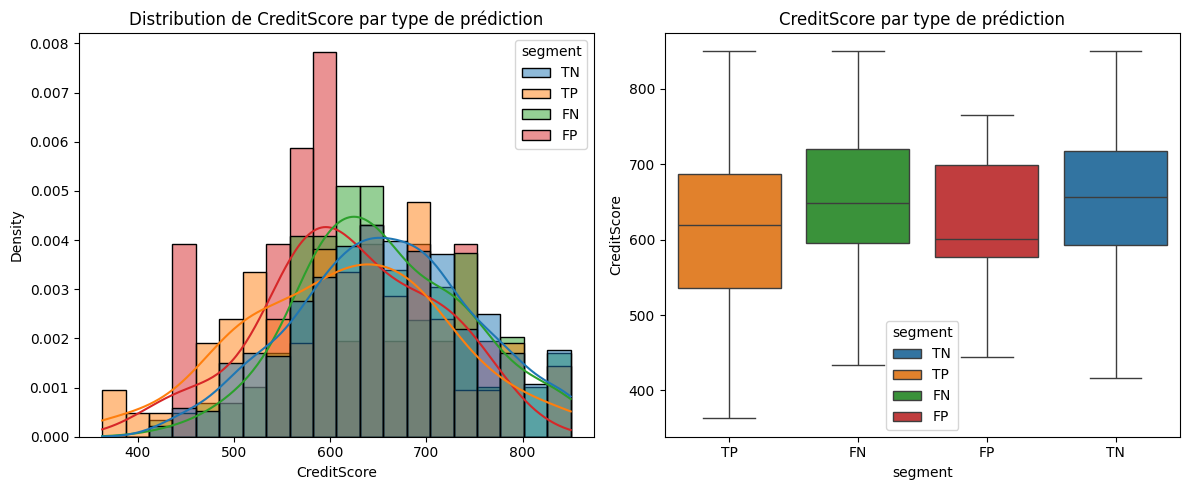

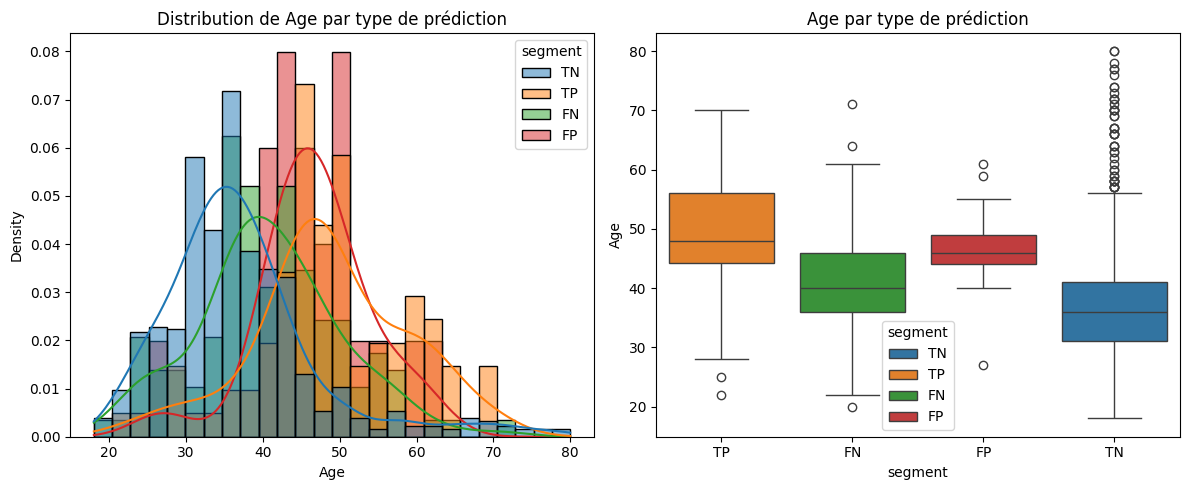

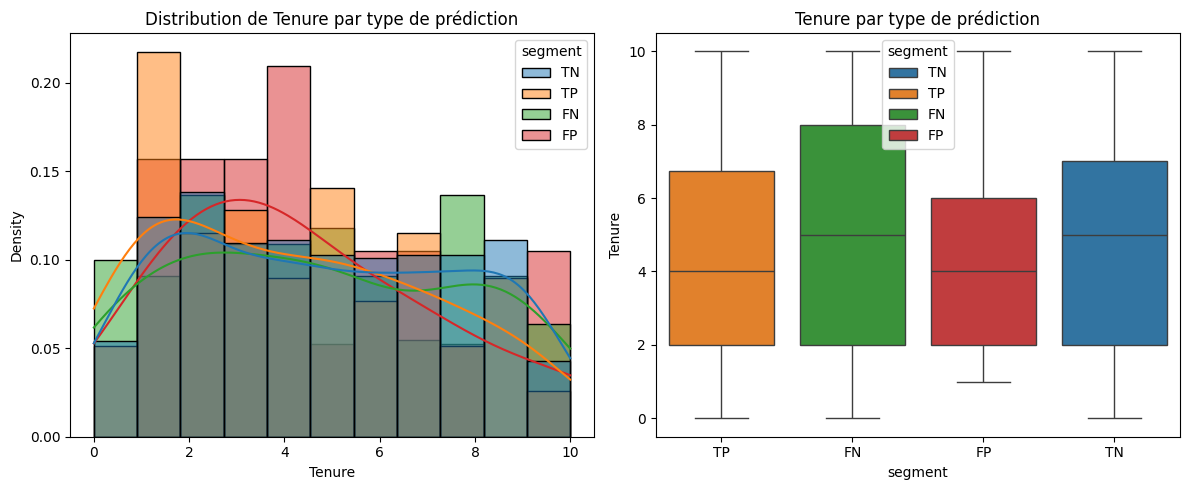

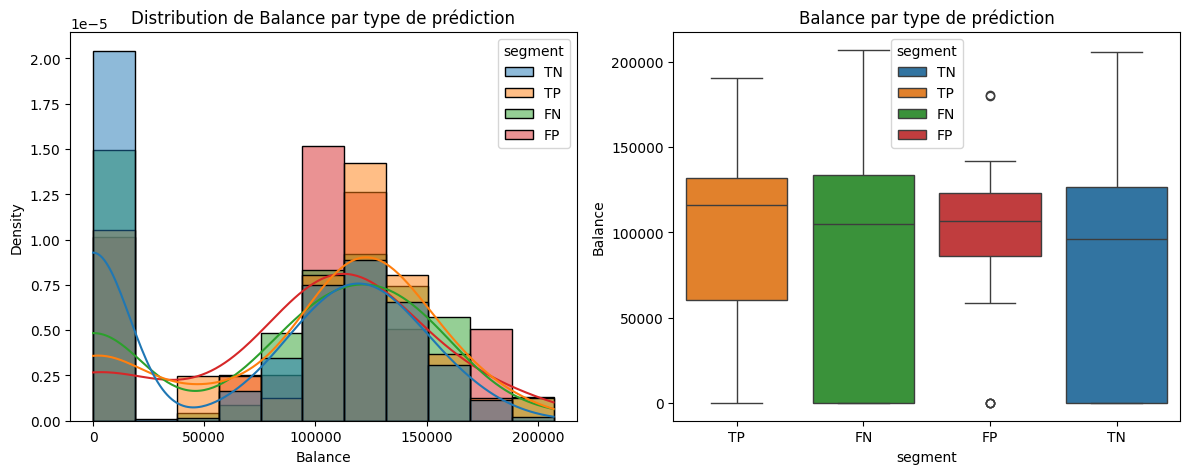

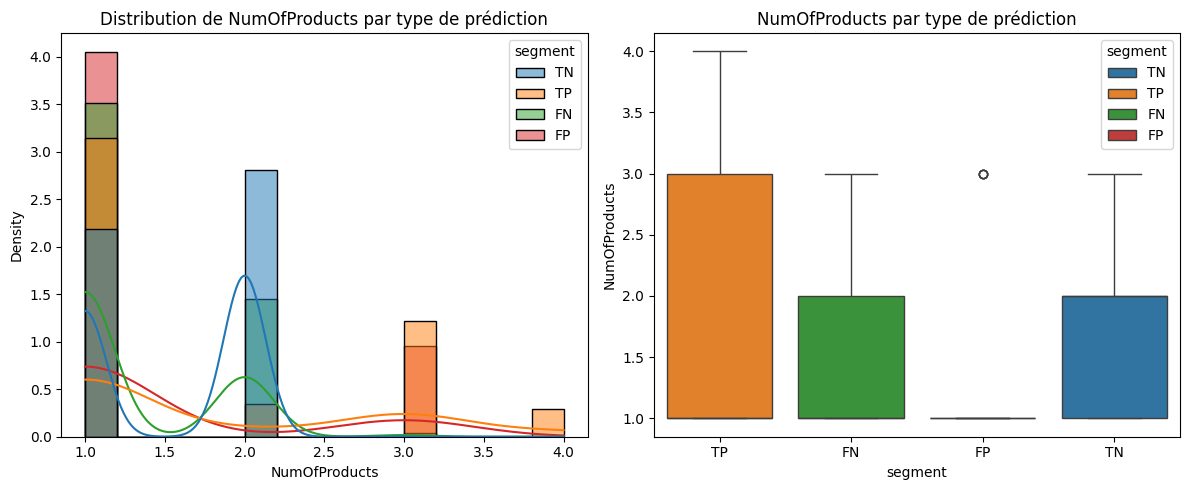

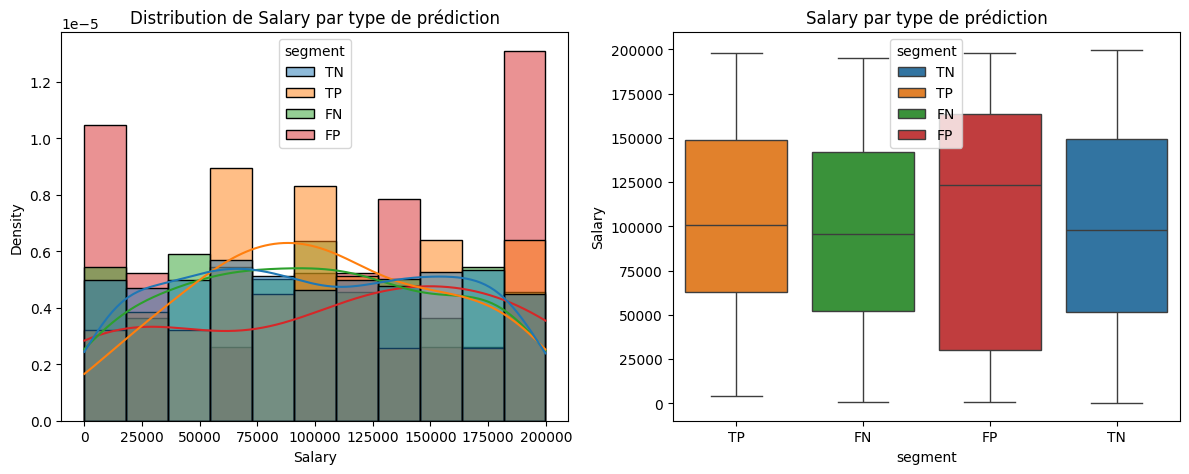

In [25]:

for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    #first plot 
    sns.histplot(
        data=eval_df,
        x=col,
        hue="segment",
        kde=True,
        stat="density",
        common_norm=False,
        multiple="layer",  # ou "stack"
        ax=ax[0]
    )
    ax[0].set_title(f"Distribution de {col} par type de prédiction")
    
    sns.boxplot(data=eval_df,
                x="segment", 
                hue="segment",
                y=col, 
                order=["TP", "FN", "FP", "TN"], 
                ax = ax[1],
                legend = True)
    ax[1].set_title(f"{col} par type de prédiction")
    
    plt.tight_layout()
    plt.show()



/tmp/ipykernel_55569/1616052975.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = eval_df.groupby(col)["segment"].value_counts(normalize=True).rename("proportion")


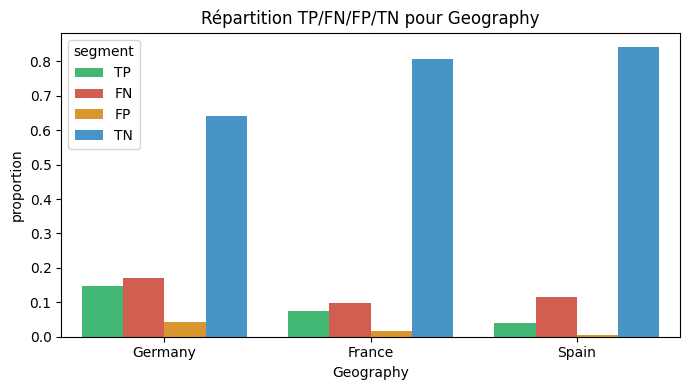

/tmp/ipykernel_55569/1616052975.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = eval_df.groupby(col)["segment"].value_counts(normalize=True).rename("proportion")


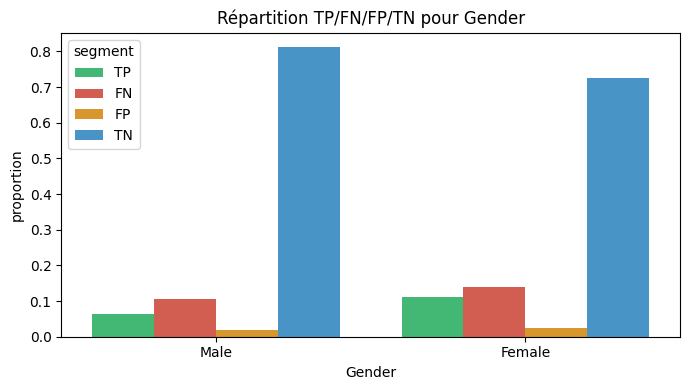

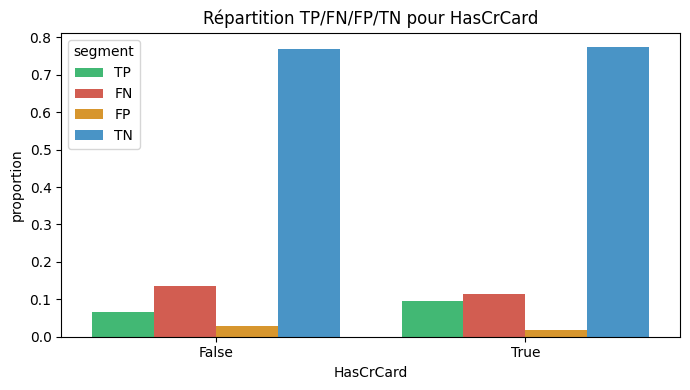

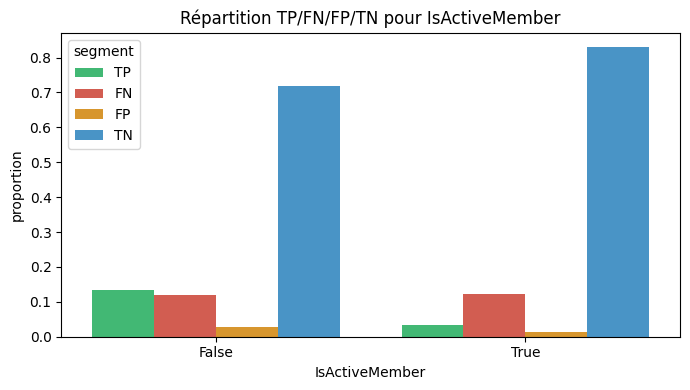

In [26]:

for col in cat_cols:
    temp = eval_df.groupby(col)["segment"].value_counts(normalize=True).rename("proportion")

    temp = temp.reset_index()

    plt.figure(figsize=(7,4))
    sns.barplot(
        data=temp,
        x=col,
        y="proportion",
        hue="segment",
        order=eval_df[col].unique(),
        hue_order=["TP","FN","FP","TN"],
        palette={
            "TP": "#2ecc71",
            "FN": "#e74c3c",
            "FP": "#f39c12",
            "TN": "#3498db",
        }
    )
    plt.title(f"Répartition TP/FN/FP/TN pour {col}")
    plt.tight_layout()
    plt.show()


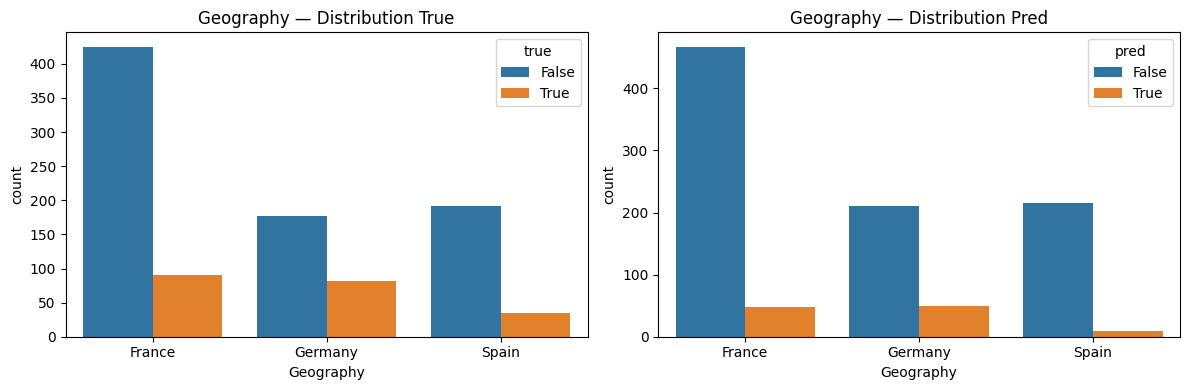

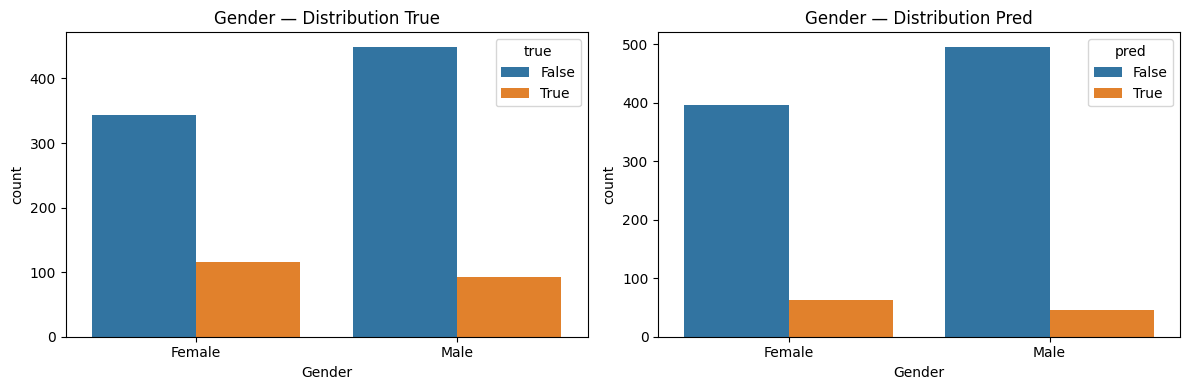

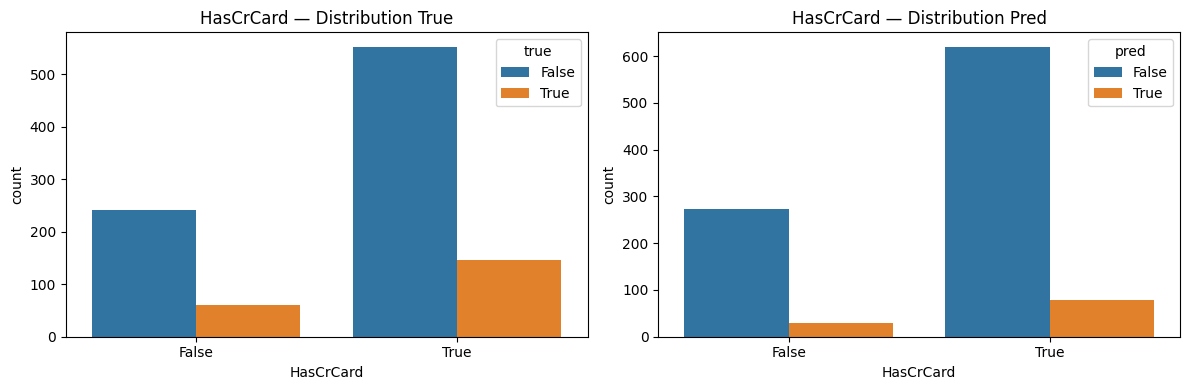

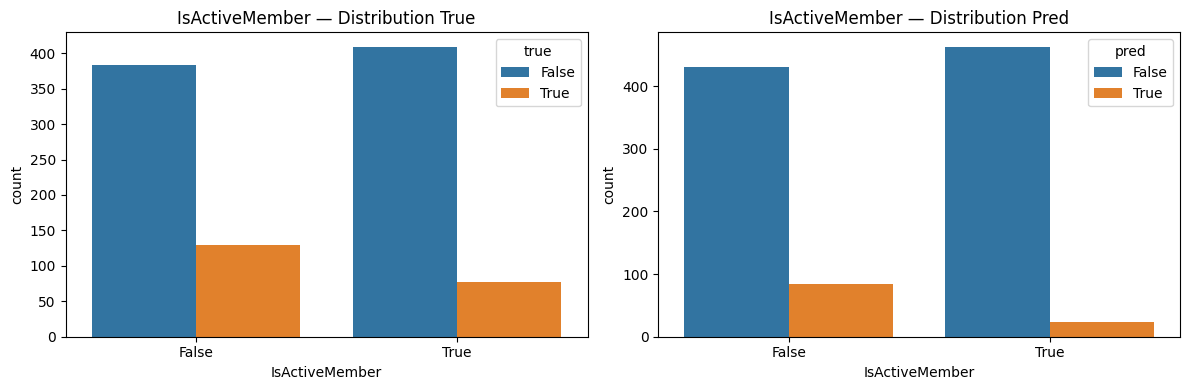

In [27]:
for col in cat_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    sns.countplot(
        data=eval_df,
        x=col,
        hue="true",
        ax=ax[0]
    )
    ax[0].set_title(f"{col} — Distribution True")

    sns.countplot(
        data=eval_df,
        x=col,
        hue="pred",
        ax=ax[1]
    )
    ax[1].set_title(f"{col} — Distribution Pred")

    plt.tight_layout()
    plt.show()


## **Part V - Fairness**

In [29]:
RF = RandomForestClassifier(n_estimators = 200, min_samples_split =  5, min_samples_leaf=5, max_features= 'sqrt',
                            max_depth= 10, class_weight= 'balanced')
RF.fit(X_cv, y_cv)
y_pred = RF.predict(X_eval)
y_proba = RF.predict_proba(X_eval)[:, 1]

_, X_eval_raw, _, _ = train_test_split(X, y, test_size=1/8, random_state=42)
df_eval = pd.DataFrame(X_eval_raw, columns=X.columns)
gender  = df_eval["Gender"].values 

**Independence**

In [30]:
gender = np.asarray(gender)
y_true = np.asarray(y_eval)
y_pred = np.asarray(y_pred)
y_proba = np.asarray(y_proba)

mask_F = (gender == "Female")
mask_M = (gender == "Male")
pr_F = (y_pred[mask_F] == 1).mean()
pr_M = (y_pred[mask_M] == 1).mean()

dp_diff  = pr_F - pr_M

print("=== Independence (Demographic Parity) ===")
print(f"P(Ŷ=1 | Female) = {pr_F:.3f}")
print(f"P(Ŷ=1 | Male) = {pr_M:.3f}")
print(f"Diff = {dp_diff:.3f}")

=== Independence (Demographic Parity) ===
P(Ŷ=1 | Female) = 0.314
P(Ŷ=1 | Male) = 0.163
Diff = 0.151


**Separation**

In [31]:
from sklearn.metrics import confusion_matrix

def tpr_fpr(y_t, y_p):
    tn, fp, fn, tp = confusion_matrix(y_t, y_p, labels=[0, 1]).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan   # recall
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    return tpr, fpr

tpr_F, fpr_F = tpr_fpr(y_true[mask_F], y_pred[mask_F])
tpr_M, fpr_M = tpr_fpr(y_true[mask_M], y_pred[mask_M])

print("\n=== Separation (Equalized Odds) ===")
print(f"TPR {'Female'}: {tpr_F:.3f}, TPR {'Male'}: {tpr_M:.3f}, Diff: {(tpr_F - tpr_M):.3f}")
print(f"FPR {'Female'}: {fpr_F:.3f}, FPR {'Male'}: {fpr_M:.3f}, Diff: {(fpr_F - fpr_M):.3f}")


=== Separation (Equalized Odds) ===
TPR Female: 0.730, TPR Male: 0.587, Diff: 0.143
FPR Female: 0.174, FPR Male: 0.076, Diff: 0.099


**Sufficiency**

In [32]:
from sklearn.metrics import brier_score_loss

bins = np.linspace(0, 1, 6)  # 5 bins: [0,0.2)...[0.8,1]

def calibration_table(y_t, y_p):
    df = pd.DataFrame({"y": y_t, "proba": y_p})
    df["bin"] = pd.cut(df["proba"], bins=bins, include_lowest=True)
    calib = df.groupby("bin").agg(
        mean_score=("proba", "mean"),
        emp_pos_rate=("y", "mean"),
        count=("y", "size")
    )
    return calib

calib_F = calibration_table(y_true[mask_F], y_proba[mask_F])
calib_M = calibration_table(y_true[mask_M], y_proba[mask_M])

brier_F = brier_score_loss(y_true[mask_F], y_proba[mask_F])
brier_M = brier_score_loss(y_true[mask_M], y_proba[mask_M])

print("\n=== Sufficiency (Calibration) ===")
print(f"Brier score Female: {brier_F:.4f}")
print(f"Brier score Male: {brier_M:.4f}")
print("\nCalibration table - Female")
print(calib_F)
print("\nCalibration table - Male")
print(calib_M)



=== Sufficiency (Calibration) ===
Brier score Female: 0.1458
Brier score Male: 0.1160

Calibration table - Female
               mean_score  emp_pos_rate  count
bin                                           
(-0.001, 0.2]    0.127944      0.072581    124
(0.2, 0.4]       0.296505      0.100000    140
(0.4, 0.6]       0.497280      0.245283    106
(0.6, 0.8]       0.701241      0.636364     55
(0.8, 1.0]       0.878254      0.911765     34

Calibration table - Male
               mean_score  emp_pos_rate  count
bin                                           
(-0.001, 0.2]    0.109574      0.026087    230
(0.2, 0.4]       0.288575      0.147727    176
(0.4, 0.6]       0.483337      0.229730     74
(0.6, 0.8]       0.703698      0.615385     39
(0.8, 1.0]       0.855977      0.863636     22


/tmp/ipykernel_55569/581823563.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby("bin").agg(
/tmp/ipykernel_55569/581823563.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby("bin").agg(
